### Import data

In [2]:
import CSV
using LeastSquaresOptim, DifferentialEquations, DelayDiffEq, DiffEqBase, Optim, Plots, Statistics, DataFrames

function get_data(path_g2, path_total)
    # Import data
    data = CSV.read(path_g2)
    total = CSV.read(path_total)

    # delete the extra index column
    deletecols!(data, 1:2)
    deletecols!(total, 1:2)

    # getting all the 8 trials
    drug = data[1:192, 1:8]
    pop = total[1:192, 1:8]

    # rescaling the experimental data assuming we have 20 initial cells for each trial
    g1 = zeros(size(drug, 1), 8)
    g2 = zeros(size(drug, 1), 8)
    g1_0 = zeros(8)
    g2_0 = zeros(8)

    init_cells = 20.0

    # Unifying the dataset to be all in the unit of [# of cells] at each time point forall the trials for a drug
    for i in 1:8
        pop[:, i] = init_cells*pop[:, i]
        g2[:, i] = 0.01*pop[:, i] .* drug[:, i]
        g1[:, i] = pop[:, i] .- g2[:, i]
        g2_0[i] = init_cells*(drug[1, i]/100.0)
        g1_0[i] = init_cells*(1 - drug[1, i]/100.0)
    end
    return pop, g2, g1, g2_0, g1_0
end

pop, g2, g1, g2_0, g1_0 = get_data("..//data//lap.csv", "..//data//lap_pop.csv");
# i is the number of the column we are using from the data

In [3]:
i = 2
function DDEmodel(du, u, h, p, t)
    du[1] = -p[1]*(h(p, t-p[3])[1]) + 2*p[2]*(h(p, t-p[4])[2]) - p[6]*u[1]
    du[2] = p[1]*(h(p, t-p[3])[1]) - p[2]*(h(p, t-p[4])[2]) - p[7]*u[2]
end

function DDEsolve(pp)
    lags = [pp[3], pp[4]]
    h(p, t) = pp[5]*ones(2)
    t = LinRange(0.0, 95.5, 192)
    tspan = (0.0, 95.5)
    u0 = [g1_0[i], g2_0[i]]
    prob = DDEProblem(DDEmodel, u0, h, tspan, pp; constant_lags = lags)
    solve(prob)
end


p  = [0.0557736, 0.0311629, 1.00062, 5.00084, 17.3839, 0.005907, 0.00194876]
low = [0.001, 0.0005, 0.5, 3.0, 7.0, 0.0001, 0.0001]
upp = [0.1, 0.1, 30.0, 30.0, 100.0, 0.1, 0.1]


par = zeros(7,8)
for j in 1:8
    function resid(pp)
        t = LinRange(0.0, 95.5, 192)
        res = zeros(2, 192)
        params = zeros(8, 7)
        sol = DDEsolve(pp)
        res[1, :] = sol(t, idxs=1).u - g1[:, j]
        res[2, :] = sol(t, idxs=2).u - g2[:, j]
        return res
    end
    results_dde = optimize(resid, p, LevenbergMarquardt(), lower = low, upper = upp)
    par[:, j] = results_dde.minimizer
end 

In [16]:
xd = [0.0, 5.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0]
para = [0.15, 0.01, 40.0, 0.01]
est = dose_response(xd, para)
plot(xd, est)
init_con = zeros(7, 4)
init_con[1:4, :] = [0.01, 0.35, 40.0, 0.05]

DimensionMismatch: DimensionMismatch("tried to assign 4-element array to 4×4 destination")

In [17]:
@. dose_response(x, p) =  p[1] + ((p[2] - p[1]) / (1 + 10^((x - p[3])*p[4])))
p1 = zeros(7, 12)
new_ps = zeros(7, 12)
init_con = zeros(7, 4)
init_con[1, :] = [0.01, 0.35, 40.0, 0.05]
init_con[2, :] = [0.01, 0.35, 40.0, 0.05]
init_con[3, :] = [0.01, 0.35, 40.0, 0.05]
init_con[4, :] = [0.01, 0.35, 40.0, 0.05]
init_con[5, :] = [0.15, 0.01, 40.0, 0.01]
init_con[6, :] = [0.15, 0.01, 40.0, 0.01]
init_con[7, :] = [0.15, 0.01, 40.0, 0.01]
for k in 1:7
    p1[k, 9:end] = init_con[k, :]
    p1[k, 1:8] = par[k, :] # alphas
    b = p1[k, :]
    function res(b)
        xdata = [0.0, 5.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0]
        residue = dose_response(xdata, b[9:end]) - b[1:8]
        return residue
    end
    lowerr = [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
#     upperr = [1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 150.0, 1.0, 1.0]
    results = optimize(res, p1[k, :], LevenbergMarquardt(), lower = lowerr)
    new_ps[k, :] = results.minimizer
end

In [20]:
# print(new_ps[1,:]) # new alphas + 4 new parameters
print(new_ps[6,:]) # new betas + 4 new parameters

[0.0239324, 0.02524, 0.0265889, 0.0308612, 0.0385581, 0.0543292, 0.0810478, 0.0859659, 0.0860938, 0.0001, 64.1884, 0.00648643]

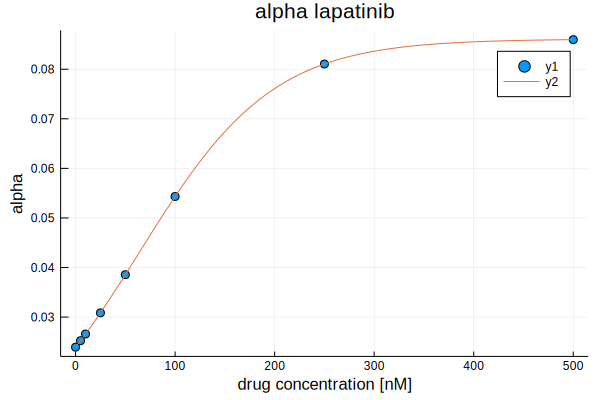

In [21]:
xdata = [0.0, 5.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0]
yd = new_ps[1, 1:8]
para = new_ps[1, 9:end]
xd = LinRange(0.0, 500.0, 100)
est = dose_response(xd, para)
scatter(xdata, yd, title = "alpha lapatinib", xlabel = "drug concentration [nM]", ylabel = "alpha")
plot!(xd, est)

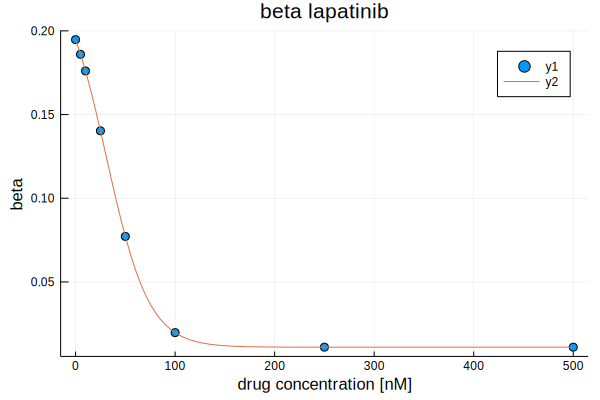

In [10]:
xdata = [0.0, 5.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0]
yd = new_ps[2, 1:8]
para = new_ps[2, 9:end]
xd = LinRange(0.0, 500.0, 100)
est = dose_response(xd, para)
scatter(xdata, yd, title = "beta lapatinib", xlabel = "drug concentration [nM]", ylabel = "beta")
plot!(xd, est)

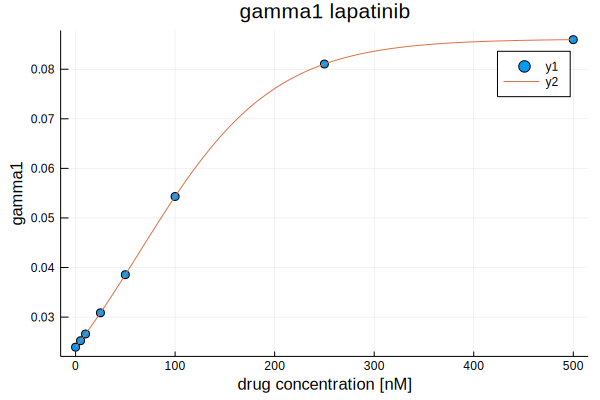

In [22]:
xdata = [0.0, 5.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0]
yd = new_ps[6, 1:8]
para = new_ps[6, 9:end]
xd = LinRange(0.0, 500.0, 100)
est = dose_response(xd, para)
scatter(xdata, yd, title = "gamma1 lapatinib", xlabel = "drug concentration [nM]", ylabel = "gamma1")
plot!(xd, est)

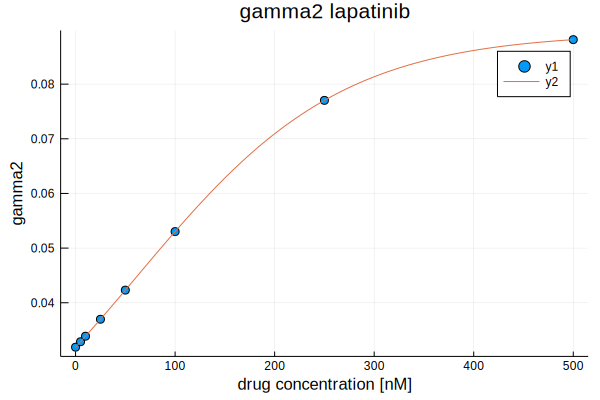

In [23]:
xdata = [0.0, 5.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0]
yd = new_ps[7, 1:8]
para = new_ps[7, 9:end]
xd = LinRange(0.0, 500.0, 100)
est = dose_response(xd, para)
scatter(xdata, yd, title = "gamma2 lapatinib", xlabel = "drug concentration [nM]", ylabel = "gamma2")
plot!(xd, est)